## Discretisation with Decision Trees


Discretisation with Decision Trees consists in using a decision tree to identify the optimal bins. When a decision tree makes a decision, it assigns an observation to one of n end leaves. Therefore, any decision tree will generate a discrete output, which values are the predictions at each of its n leaves.

How to do discretisation with trees?

- 1) Train a decision tree of limited depth (2, 3  or 4) using the variable we want to discretise and the target.
- 2) Replace the values by the output returned by the tree. 


### Advantages

- Usually the output returned by the decision tree is monotonically related to the target.
- The tree end nodes, or bins in the discretised variable show decreased entropy: that is, the observations within each bin are more similar among themselves than to those of other bins.

### Limitations

- Prone over-fitting
- More importantly, some tuning of the tree parameters needed to obtain the optimal number of splits (e.g., tree depth, minimum number of samples in one partition, maximum number of partitions, and a minimum information gain). This it can be time consuming.

## In this demo

We will learn how to perform discretisation with decision trees.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score

# for encoding with feature-engine
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder

pd.set_option('display.max_columns', None)

## DATASET

In [2]:
data_raw = pd.read_csv('C://Users/gusal/machine learning/Feature engineering/loan_reduced.csv')

In [3]:
data_raw.head()

,loan_status,total_pymnt,total_pymnt_inv
0,Current,167.02,167.02
1,Current,1507.11,1507.11
2,Current,353.89,353.89
3,Current,286.71,286.71
4,Current,1423.21,1423.21


In [4]:
data_raw['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

## We need to map 'loan_status'

In [5]:
# first let's create a dictionary with the mappings of categories to numbers

ordinal_mapping = {
    k: i
    for i, k in enumerate(data_raw['loan_status'].unique(), 0)
}

ordinal_mapping

{'Current': 0,
 'Fully Paid': 1,
 'Late (31-120 days)': 2,
 'In Grace Period': 3,
 'Charged Off': 4,
 'Late (16-30 days)': 5,
 'Default': 6,
 'Does not meet the credit policy. Status:Fully Paid': 7,
 'Does not meet the credit policy. Status:Charged Off': 8}

The dictionary indicates which number will replace each category. Numbers were assigned arbitrarily from 0 to n - 1 where n is the number of distinct categories.

In [6]:
# replace the labels with the integers

data_raw['loan_status'] = data_raw['loan_status'].map(ordinal_mapping)


In [7]:
data_raw.head()

,loan_status,total_pymnt,total_pymnt_inv
0,0,167.02,167.02
1,0,1507.11,1507.11
2,0,353.89,353.89
3,0,286.71,286.71
4,0,1423.21,1423.21


In [8]:
data_raw['loan_status'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [9]:
inputs = data_raw.drop(['loan_status'], axis = 1)
target = data_raw.loan_status

In [10]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    inputs,
    target,
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1582464, 2), (678199, 2))

In [11]:
# example: build Classification tree using total_pymnt to predict Survived

tree_model = DecisionTreeClassifier(max_depth = 3, criterion = 'entropy', min_samples_split=2)

tree_model.fit(X_train['total_pymnt'].to_frame(), y_train)

X_train['total_pymnt_tree'] = tree_model.predict_proba(X_train['total_pymnt'].to_frame())[:,1]

# criterion = 'entropy', max_depth=3, min_samples_split=2, min_samples_leaf=2

C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
X_test['total_pymnt_tree'] = tree_model.predict_proba(X_test['total_pymnt'].to_frame())[:,1]

C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
X_train['total_pymnt_tree'].unique()

array([6.98258380e-01, 2.29868115e-01, 8.80921510e-02, 5.92314176e-01,
       1.38506323e-01, 4.30603378e-01, 8.20987016e-01, 1.28598756e-04])

Text(0, 0.5, 'loan_status')

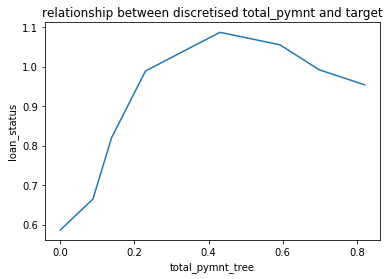

In [14]:
# relationship with target

pd.concat([X_train, y_train], axis=1).groupby(['total_pymnt_tree'])['loan_status'].mean().plot()
plt.title('relationship between discretised total_pymnt and target')
plt.ylabel('loan_status')

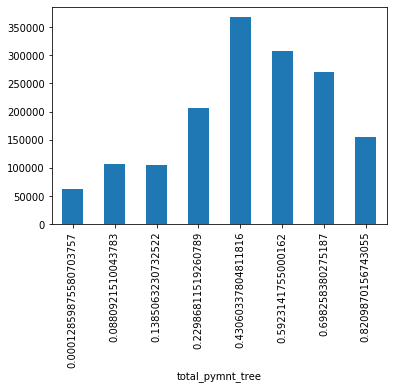

In [15]:
# number of intervals per probabilistic bucket / bin

X_train.groupby(['total_pymnt_tree'])['total_pymnt'].count().plot.bar()

In [16]:
# let's see the total_pymnt_tree limits buckets generated by the tree
# by capturing the minimum and maximum total_pymnt per each probability bucket, 
# we get an idea of the bucket cut-offs

pd.concat( [X_train.groupby(['total_pymnt_tree'])['total_pymnt'].min(),
            X_train.groupby(['total_pymnt_tree'])['total_pymnt'].max()], axis=1)

,total_pymnt,total_pymnt
total_pymnt_tree,,
0.000129,0.000000,999.920000
0.088092,1000.000000,1999.960000
0.138506,1999.980000,3012.780000
0.229868,3012.787250,5222.630000
0.430603,5222.639355,10001.400000
0.592314,10001.409035,15980.310000
0.698258,15980.315598,26347.110000
0.820987,26347.150294,63296.877868


In [17]:
X_train['total_pymnt_tree'] = X_train['total_pymnt_tree'].astype(object)
X_test['total_pymnt_tree'] = X_test['total_pymnt_tree'].astype(object)

C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
X_train['total_pymnt_tree'].dtypes

dtype('O')

In [19]:
X_test['total_pymnt_tree'].dtypes

dtype('O')

the variables do not show a monotonic relationship between the intervals of the discrete variable and the target. We can encode the intervals to return a monotonic relationship:

# Ordered Integer encoding with Feature Engine

In [20]:
ordinal_enc = OrdinalCategoricalEncoder(
    # NOTE that we indicate ordered in the encoding_method, otherwise it assings numbers arbitrarily
    encoding_method='ordered',
    variables=['total_pymnt_tree'])

In [21]:
# when fitting the transformer, we need to pass the target as well
# just like with any Scikit-learn predictor class

ordinal_enc.fit(X_train, y_train)

OrdinalCategoricalEncoder(encoding_method='ordered',
                          variables=['total_pymnt_tree'])

In [22]:
X_train.head()

,total_pymnt,total_pymnt_inv,total_pymnt_tree
2129602,17611.454252,17552.75,0.698258
1448708,4959.780000,4959.78,0.229868
1330312,25465.050000,25465.05,0.698258
1113017,17737.720000,17737.72,0.698258
157207,1248.760000,1248.76,0.0880922


In [23]:
# in the encoder dict we can observe each of the top categories
# selected for each of the variables

ordinal_enc.encoder_dict_

{'total_pymnt_tree': {0.00012859875580703757: 0,
  0.0880921510043783: 1,
  0.1385063230732522: 2,
  0.8209870156743055: 3,
  0.22986811519260789: 4,
  0.698258380275187: 5,
  0.5923141755000162: 6,
  0.43060337804811816: 7}}

In [24]:
# this is the list of variables that the encoder will transform

ordinal_enc.variables

['total_pymnt_tree']

In [25]:
X_train = ordinal_enc.transform(X_train)
X_test = ordinal_enc.transform(X_test)



In [26]:
# let's explore the result
X_train.head()

,total_pymnt,total_pymnt_inv,total_pymnt_tree
2129602,17611.454252,17552.75,5
1448708,4959.780000,4959.78,4
1330312,25465.050000,25465.05,5
1113017,17737.720000,17737.72,5
157207,1248.760000,1248.76,1


Text(0, 0.5, 'loan_status')

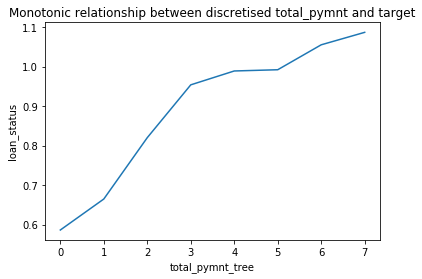

In [27]:
# relationship with target

pd.concat([X_train, y_train], axis=1).groupby(['total_pymnt_tree'])['loan_status'].mean().plot()
plt.title('Monotonic relationship between discretised total_pymnt and target')
plt.ylabel('loan_status')

Text(0, 0.5, 'loan_status')

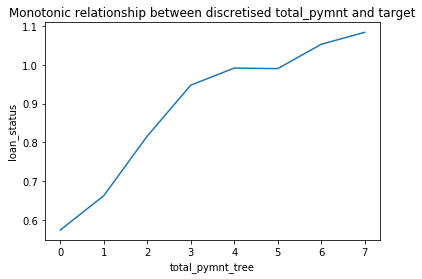

In [28]:
# relationship with target

pd.concat([X_test, y_test], axis=1).groupby(['total_pymnt_tree'])['loan_status'].mean().plot()
plt.title('Monotonic relationship between discretised total_pymnt and target')
plt.ylabel('loan_status')

### Tree visualisation

In [29]:
# we can go ahead and visualise the tree by saving the model to a file,
# and opening that file in the below indicated link

with open("tree_model.txt", "w") as f:
    f = export_graphviz(tree_model, out_file=f)

# go here to open the file: http://webgraphviz.com

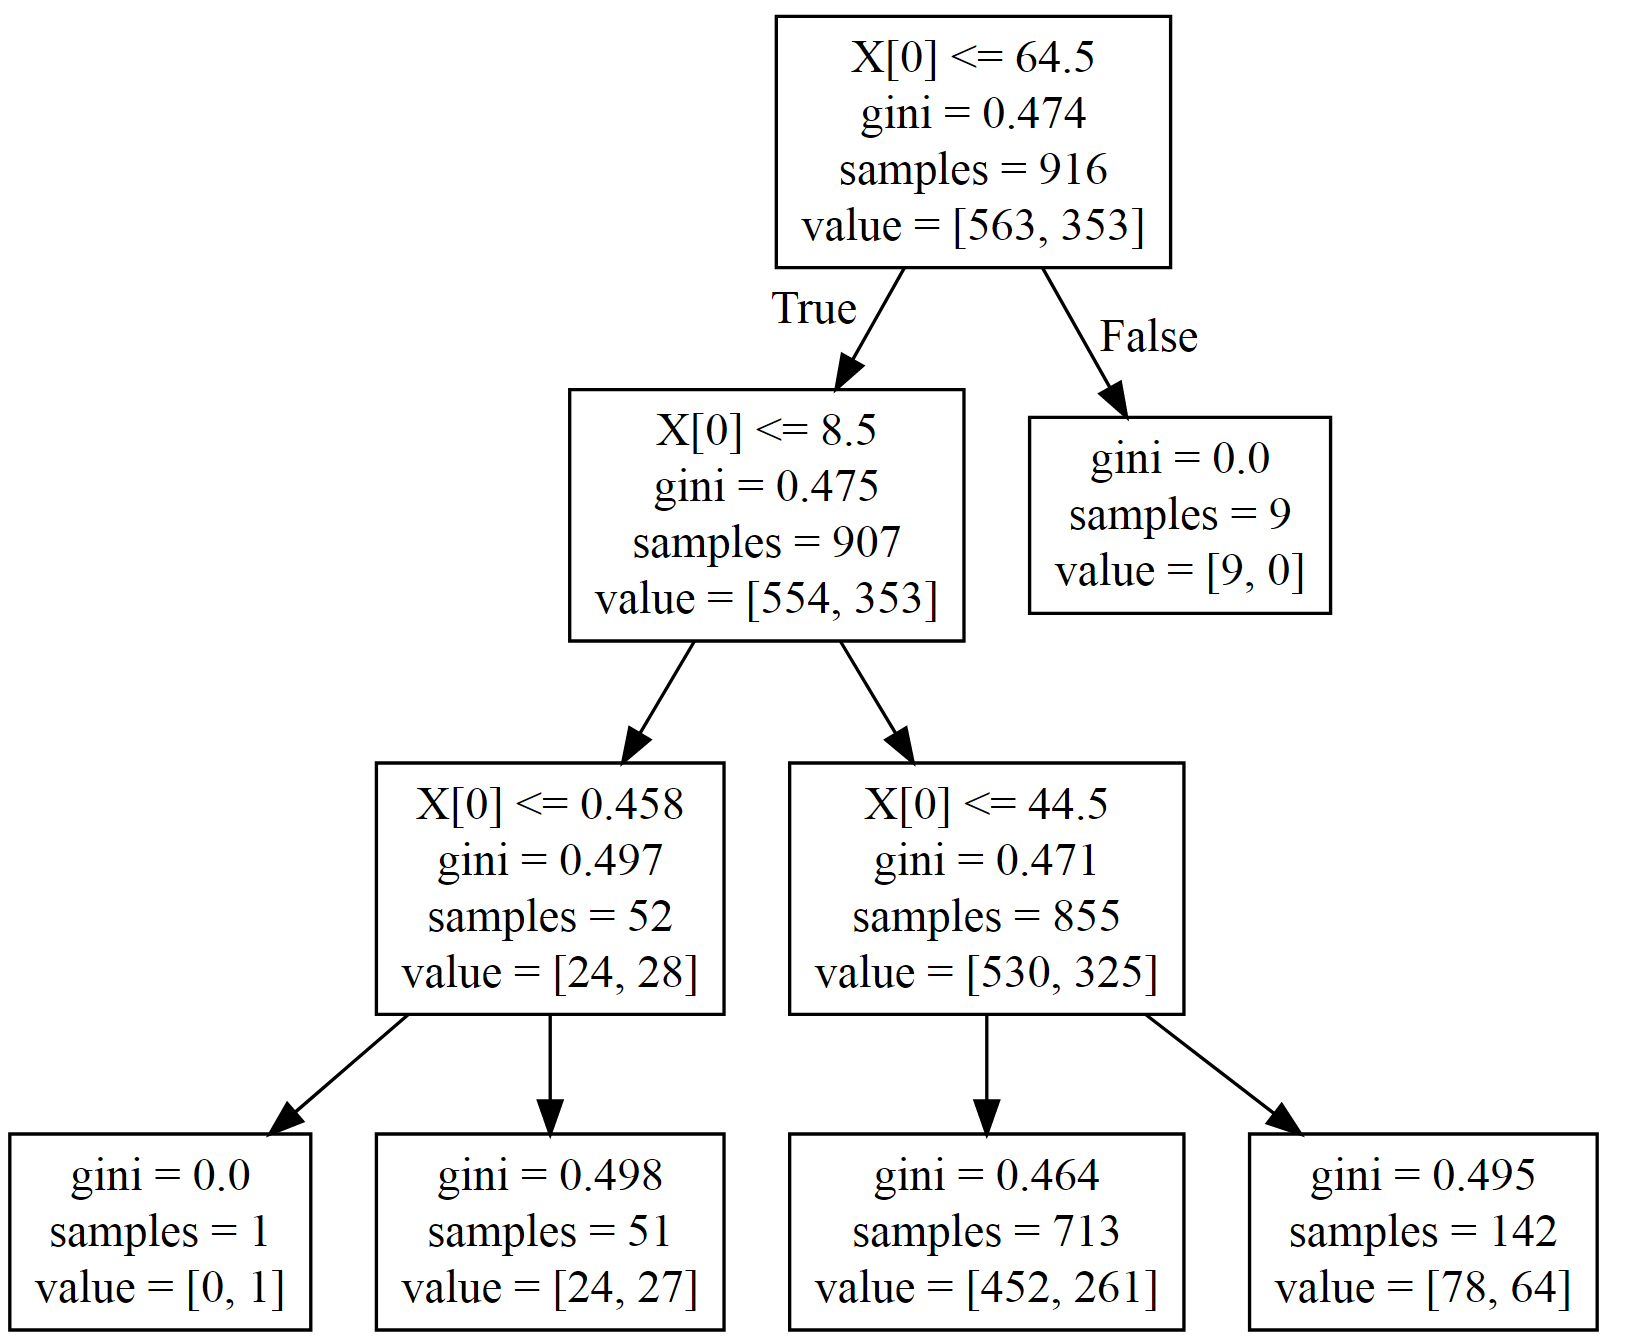

In [30]:
# this is what you should see if you do what is described in the previous cell

# I saved the image you should retrieve in the server above into a png, and then load
# it here to smooth the demo

# the  plot indicates  the age cut-offs at each node, and also the number of samples at each node, and 
# the gini

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "tree_visualisation.png"
Image(filename = PATH , width=1000, height=1000)